Processando: carolina-hardwood-external-door-77-p.jpeg

image 1/1 c:\Users\Caio Fuzita\Documents\GitHub\teste-pi\images\carolina-hardwood-external-door-77-p.jpeg: 640x640 1 door, 66.7ms
Speed: 5.0ms preprocess, 66.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


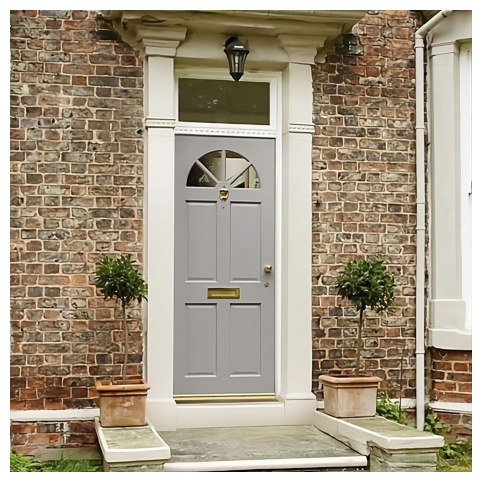


Resultados para carolina-hardwood-external-door-77-p.jpeg:

Resultados do YOLO:
Classe: door, Confiança: 0.83, Coordenadas: [[687.9140014648438, 544.0369262695312, 1106.03369140625, 1610.6795654296875]]

Resultado do ResNet:
Classe: door, Confiança: 1.00
Processando: images (1).jpg

image 1/1 c:\Users\Caio Fuzita\Documents\GitHub\teste-pi\images\images (1).jpg: 640x640 (no detections), 66.8ms
Speed: 3.1ms preprocess, 66.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


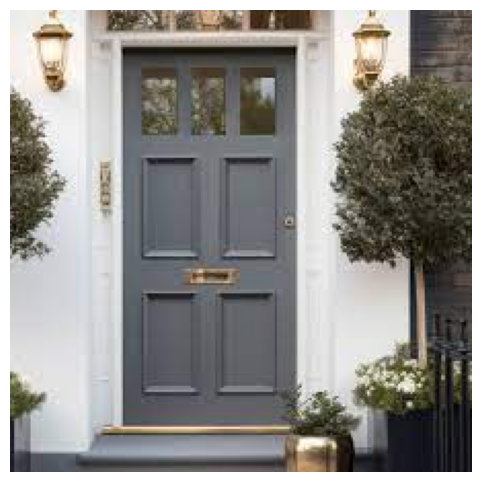


Resultados para images (1).jpg:

Resultados do YOLO:
Não identificado

Resultado do ResNet:
Classe: door, Confiança: 0.87


In [29]:
import os
import torch
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO
import torchvision.models as models
from torchvision import transforms

CLASSES = [
    "door",            # 0
    "cabinetDoor",     # 1
    "refrigeratorDoor",# 2
    "window",          # 3
    "chair",           # 4
    "table",           # 5
    "cabinet",         # 6
    "couch",           # 7
    "openedDoor",      # 8
    "pole"             # 9
]

# Função para carregar o modelo YOLO
def load_yolo_model(model_path):
    return YOLO(model_path)

# Função para carregar o modelo ResNet18
def load_resnet_model(model_path, num_classes=10):
    model = models.resnet18(pretrained=False)
    model.fc = torch.nn.Linear(model.fc.in_features, num_classes)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    return model

# Função para fazer a inferência com o modelo YOLO
def infer_yolo(model, img_path, conf_threshold=0.8):
    results = model(img_path, conf=conf_threshold)
    detections = []
    for detection in results:
        for box in detection.boxes:
            detections.append({
                "classe": int(box.cls),
                "confiança": float(box.conf),
                "coordenadas": box.xyxy.tolist()
            })
    return detections

# Função para fazer a inferência com o modelo ResNet18
def infer_resnet(model, img_path):
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_tensor = transform(img).unsqueeze(0)
    
    with torch.no_grad():
        output = model(img_tensor)
        probabilities = torch.nn.functional.softmax(output, dim=1)
        confidence, predicted_class = torch.max(probabilities, 1)
    return predicted_class.item(), confidence.item()

# Função para desenhar os resultados na imagem
def draw_results(img_path, yolo_results, resnet_result):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Converter para RGB para exibição com Matplotlib
    
    # Exibir a imagem original com Matplotlib
    plt.figure(figsize=(10, 6))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    # Imprimir os resultados no console
    print(f"\nResultados para {os.path.basename(img_path)}:")

    # Resultados do YOLO
    print("\nResultados do YOLO:")
    # Verificar se há resultados do YOLO
    if not yolo_results:
        print("Não identificado")
    else:
        for det in yolo_results:
            classe = CLASSES[det['classe']]
            confiança = det['confiança']
            print(f"Classe: {classe}, Confiança: {confiança:.2f}, Coordenadas: {det['coordenadas']}")

    # Resultado do ResNet
    print("\nResultado do ResNet:")
    print(f"Classe: {resnet_result['classe']}, Confiança: {resnet_result['confiança']:.2f}")

# Função para processar todas as imagens da pasta
def process_images(yolo_model, resnet_model, folder_path):
    for img_file in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_file)
        if not img_path.lower().endswith(('.png', '.jpg', '.jpeg')):
            continue
        
        print(f"Processando: {img_file}")
        yolo_results = infer_yolo(yolo_model, img_path)
        resnet_class, resnet_confidence = infer_resnet(resnet_model, img_path)
        
        resnet_result = {
            "classe": CLASSES[resnet_class],
            "confiança": resnet_confidence
        }

        draw_results(img_path, yolo_results, resnet_result)

# Caminhos para os modelos e pasta de imagens
yolo_model_path = './modelos/best.pt'
resnet_model_path = './modelos/resnet18_model.pth'
images_folder = './images'

# Carregar os modelos
yolo_model = load_yolo_model(yolo_model_path)
resnet_model = load_resnet_model(resnet_model_path)

# Processar as imagens
process_images(yolo_model, resnet_model, images_folder)
